In [2]:
# using python 3.6
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import itertools
%matplotlib inline

In [3]:
# camera calibration and distrotion coef
# chess board is 9x6 (internal corners)

# the object points (stay same) and image point lists
rows = 6
cols = 9

objpts = list(zip(list(range(cols))*rows, 
             list(itertools.chain(*[[i]*cols for i in range(rows)])), 
             [0]*rows*cols))
# convert from tuple to list to arr 
objpts = np.array([list(i) for i in objpts], np.float32) 
objptsLst = []
imgptsLst = []

In [4]:
# perform calibration by iterating through calib. images
image_files = os.listdir('./camera_cal/')

for image_file in image_files:
    image_file = './camera_cal/'+image_file # get image path
    image = plt.imread(image_file)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # find the image points (chess board corners in that image)
    ret, imgpts = cv2.findChessboardCorners(gray, (cols, rows), None)
    if ret: # if a valid value has been returned
        imgptsLst.append(imgpts)
        objptsLst.append(objpts)

In [5]:
# use img and obj points to find calibration mat and distortion coef
ret, mtx, dis, rvecs, tvecs = cv2.calibrateCamera(objptsLst, imgptsLst,
                                                 gray.shape[::-1], None, None)

In [6]:
# undistorts any input image by same camera as above
def undistort_img(img, mtx, dis):
    return cv2.undistort(img, mtx, dis, None, mtx)

Text(0.5,1,'Undistorted')

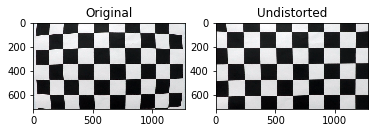

In [18]:
# display sample output
image_file = './camera_cal/calibration1.jpg'
image = cv2.imread(image_file)
undist_image = undistort_img(image, mtx, dis)

f,ax = plt.subplots(1,2)
ax[0].imshow(image)
ax[0].set_title('Original')
#plt.title('Original')
ax[1].imshow(undist_image)
ax[1].set_title('Undistorted')
#plt.title('Undistorted')

In [19]:
# remove noise from img using gaussian blurring
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [20]:
# apply color and gradient thresholds
# first gradient thresholds
def apply_thresh(img, sobel_kernel=15, 
                 gradx_thresh=[0,150],angle_thresh=[0.5,2],
                 saturation_thresh=[100,255], hue_thresh=[10,100]):
    
    # first, the gradient based thresholds:
    # convert to grayscale
    if len(img.shape) > 2:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else: 
        gray = img
    # apply sobel operator
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # get abs of sobel
    sobel_x = np.absolute(sobel_x)
    sobel_y = np.absolute(sobel_y)
    # get the angel
    grad_angle = np.arctan2(sobel_y, sobel_x)
    # normalize sobel_x and convert to 8-bit (0 to 255)
    max_p = np.max(sobel_x)
    sobel_x = np.uint8(255*sobel_x/max_p)
    # generate binary image based on thresholds
    low_x, high_x = gradx_thresh
    low_ang, high_ang = angle_thresh
    binary_grad = np.multiply(np.multiply(sobel_x>=low_x, sobel_x<=high_x), 
                np.multiply(grad_angle>=low_ang, grad_angle<=high_ang))
    plt.imshow(binary_grad, cmap='gray')
    plt.show()
    # next, the hls and color based thresholds:
    # get the different channels
    R,G,B = img[:,:,0], img[:,:,1], img[:,:,2]
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H,L,S = hls_img[:,:,0], hls_img[:,:,1], hls_img[:,:,2]
    # apply HLS and COLOR thresholds
    low_H, high_H = hue_thresh
    low_S, high_S = saturation_thresh
    binary_hls = np.multiply(np.multiply(H>=low_H, H<=high_H),
                    np.multiply(S>=low_S, S<=high_S))
    plt.imshow(binary_hls, cmap='gray')
    plt.show()
    # combine to generate one binary image
    binary_output = np.multiply(binary_grad, binary_hls)
    return np.uint8(binary_hls)
    

In [21]:
# apply sobel (gradient) thresh
def apply_sobel_thresh(img, sobel_kernel=15, gradx_thresh=[0,150], angle_thresh=[0.5,2], show=False):
    # convert to grayscale
    if len(img.shape) > 2:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else: 
        gray = img
    # apply sobel operator
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # get abs of sobel
    sobel_x = np.absolute(sobel_x)
    sobel_y = np.absolute(sobel_y)
    # get the angel
    grad_angle = np.arctan2(sobel_y, sobel_x)
    # normalize sobel_x and convert to 8-bit (0 to 255)
    max_p = np.max(sobel_x)
    sobel_x = np.uint8(255*sobel_x/max_p)
    # generate binary image based on thresholds
    low_x, high_x = gradx_thresh
    low_ang, high_ang = angle_thresh
    binary_grad = np.multiply(np.multiply(sobel_x>=low_x, sobel_x<=high_x), 
                np.multiply(grad_angle>=low_ang, grad_angle<=high_ang))
    if show:
        plt.imshow(binary_grad, cmap='gray')
        plt.show()
    
    return np.uint8(binary_grad)

In [22]:
# apply Hue and Saturation thresh
# must insert a color img
def apply_HS_thresh(img, S_thresh=[100,255], H_thresh=[20,50], show=False):
    
    # convert to hls image
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # get the channels
    H,L,S = hls_img[:,:,0], hls_img[:,:,1], hls_img[:,:,2]
    # apply HLS and COLOR thresholds
    low_H, high_H = H_thresh
    low_S, high_S = S_thresh
    binary_hls = np.multiply(np.multiply(H>=low_H, H<=high_H),
                    np.multiply(S>=low_S, S<=high_S))
    if show:
        plt.imshow(binary_hls, cmap='gray')
        plt.show()
    return np.uint8(binary_hls)

In [23]:
# apply RGB thresh
# must insert a color RGB img
def apply_RGB_thresh(img, R_thresh=[100,255], G_thresh=[20,50], B_thresh=[0,255], show=False):
    
    # get the different channels
    R,G,B = img[:,:,0], img[:,:,1], img[:,:,2]
    # apply COLOR thresholds
    low_R, high_R = R_thresh
    low_G, high_G = G_thresh
    low_B, high_B = B_thresh
    binary_rgb = np.multiply(np.multiply(np.multiply(R>=low_R, R<=high_R),
                    np.multiply(G>=low_G, G<=high_G)),np.multiply(B>=low_B, B<=high_B))
    if show:
        plt.imshow(binary_rgb, cmap='gray')
        plt.show()
    return np.uint8(binary_rgb)

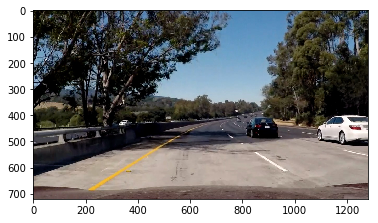

In [24]:
image = plt.imread('./test_images/test5.jpg')
plt.imshow(image)
undist_img = undistort_img(image,mtx,dis)
#gray = cv2.cvtColor(undist_img, cv2.COLOR_RGB2GRAY)

Text(0.5,1,'Undistorted')

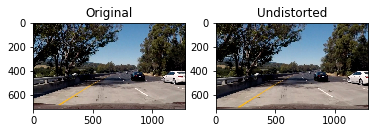

In [27]:
f,ax = plt.subplots(1,2)
ax[0].imshow(image)
ax[0].set_title('Original')
#plt.title('Original')
ax[1].imshow(undist_img)
ax[1].set_title('Undistorted')
#plt.title('Undistorted')

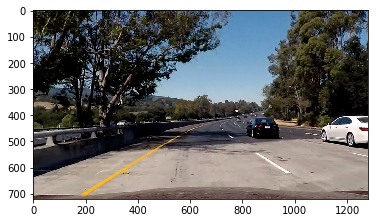

In [40]:
kernel = np.array([[-1,-1,-1,-1,-1],
                             [-1,2,2,2,-1],
                             [-1,2,16,2,-1],
                             [-1,2,2,2,-1],
                             [-1,-1,-1,-1,-1]]) / 16.

sharp = cv2.filter2D(undist_img, -1, kernel)
plt.imshow(sharp)

Text(0.5,1,'Sharpened Image')

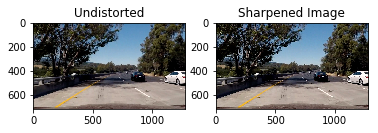

In [41]:
f,ax = plt.subplots(1,2)

ax[0].imshow(undist_img)
ax[0].set_title('Undistorted')
ax[1].imshow(sharp)
ax[1].set_title('Sharpened Image')
#plt.title('Original')

In [35]:
def warp(img):
    # get img dims 
    h,w = img.shape[:2]
    # the source and destination points
    src = np.float32([[575,470],[750,470],[260,670],[1100,670]])
    dst = np.float32([[200,0],[w-200,0],[200,h],[w-200,h]])
    #src = np.float32([[595,450],[690,450],[1040,660],[260,660]])
    #dst = np.float32([[300,100],[1060,100],[1060,660],[250,660]])
    # get the transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src) # get the inverse transform
    warped = cv2.warpPerspective(img, M, 
            (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    return warped, M_inv

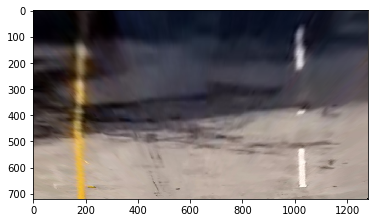

In [42]:
wrap_img, _ = warp(blur_img)
plt.imshow(wrap_img)

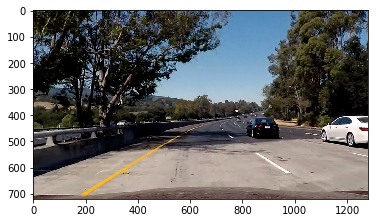

In [45]:
plt.imshow(sharp)

Text(0.5,1,'Warpped Image')

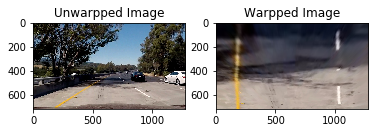

In [46]:
f,ax = plt.subplots(1,2)

ax[0].imshow(sharp)
ax[0].set_title('Unwarpped Image')
ax[1].imshow(wrap_img)
ax[1].set_title('Warpped Image')

Text(0.5,1,'Left Lane')

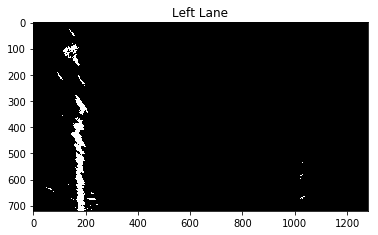

In [52]:
one_img = apply_HS_thresh(wrap_img, [0,255], [20,75])
plt.imshow(one_img, 'gray')
plt.title('Left Lane')

Text(0.5,1,'Right Lane')

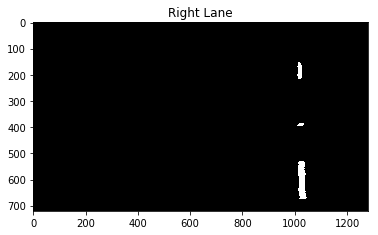

In [51]:
two_img = apply_RGB_thresh(wrap_img, [190,255],[190,255],[190,255])
plt.imshow(two_img, 'gray')
plt.title('Right Lane')

In [55]:
thresh_img = (one_img + two_img) > 0

Text(0.5,1,'Combined')

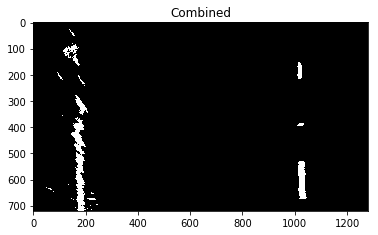

In [56]:
plt.imshow(thresh_img, 'gray')
plt.title('Combined')

In [58]:
np.uint8(thresh_img)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [73]:
# mask to remove unnecessary points
def mask(bit_img):
    w, h = bit_img.shape[:2]
    mask_coords = np.int32([[500,450],[780,450],[1150,h],[200,h]])
    mask = np.zeros_like(bit_img)
    mask = cv2.fillConvexPoly(mask, mask_coords, 255) # we only have one color channel
    img_masked = cv2.bitwise_and(bit_img, mask)
    return img_masked

In [74]:
bit_warped = thresh_img

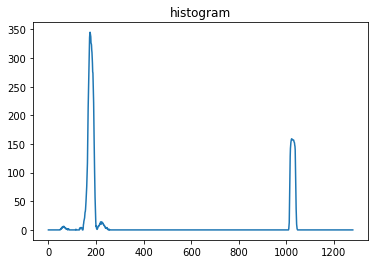

In [75]:
# histogram
hist = np.sum(bit_warped[bit_warped.shape[0]//2:,:], axis=0)
plt.plot(hist)
plt.title('histogram')
out_img = np.dstack((bit_warped, bit_warped, bit_warped))*255

In [76]:
midpoint = np.int(hist.shape[0]/2)

In [77]:
leftx_base = np.argmax(hist[:midpoint])
rightx_base = np.argmax(hist[midpoint:]) + midpoint

In [78]:
nwinds = 9
window_h = np.int(bit_warped.shape[0]/nwinds)
nonzero_pos = bit_warped.nonzero() 
nonzero_y, nonzero_x = nonzero_pos # all the chosen pix (regarless of window)

In [79]:
# set starting positions
leftx_curr = leftx_base
rightx_curr = rightx_base
# width of the windows
width = 100 # NOTE: var
# threshold to recenter window
pix_thresh = 50 # NOTE: var
# lists to stor inds
left_lane_idx = []
right_lane_idx = []

In [80]:
len(nonzero_y)

18180

In [81]:
for window in range(nwinds):
    # starting all the way at the bottom
    y_up = bit_warped.shape[0] - (window+1)*window_h
    y_down = bit_warped.shape[0] - window*window_h
    x_left_l = leftx_curr - width
    x_left_r = leftx_curr + width
    x_right_l = rightx_curr - width
    x_right_r = rightx_curr + width
    # draw the windows (first left and then right)
    cv2.rectangle(out_img, (x_left_l, y_up), (x_left_r, y_down), (0,255,0), 2)
    cv2.rectangle(out_img, (x_right_l, y_up), (x_right_r, y_down), (0,255,0), 2)
    #plt.imshow(np.uint8(out_img))
    #plt.title('Windows')
    # find pixels that are within this window - the 'good' pixels
    # the [0] at the end is because the original list is just 1-D arr NOT 2D
    good_left = ((nonzero_y < y_down) & (nonzero_y >= y_up) &\
                (nonzero_x >= x_left_l) & (nonzero_x <= x_left_r)).nonzero()[0]
    good_right = ((nonzero_y < y_down) & (nonzero_y >= y_up) &\
                (nonzero_x >= x_right_l) & (nonzero_x <= x_right_r)).nonzero()[0]
    # append them to list
    left_lane_idx.append(good_left)
    right_lane_idx.append(good_right)
    # recenter window (for next iter) if needed
    if len(good_left) > pix_thresh:
        leftx_curr = np.int(np.mean(nonzero_x[good_left]))
    if len(good_right) > pix_thresh:
        rightx_curr = np.int(np.mean(nonzero_x[good_right]))

In [82]:
# concatenate the arrays
left_lane_idx = np.concatenate(left_lane_idx)
right_lane_idx = np.concatenate(right_lane_idx)
# get list of x and y coords
left_x = nonzero_x[left_lane_idx]
left_y = nonzero_y[left_lane_idx]
right_x = nonzero_x[right_lane_idx]
right_y = nonzero_y[right_lane_idx]

In [69]:
# fit a polynomial
left_poly_fit = np.polyfit(left_y, left_x, 2)
right_poly_fit = np.polyfit(right_y, right_x, 2)

Text(0.5,1,'Lane Lines')

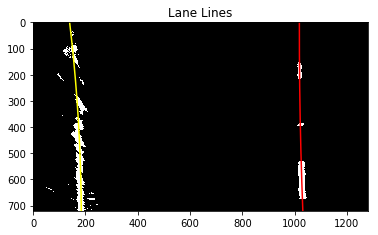

In [87]:
#visualize the result
# Generate x and y values for plotting
ploty = np.linspace(0, bit_warped.shape[0]-1, bit_warped.shape[0] )
left_fitx = left_poly_fit[0]*ploty**2 + \
            left_poly_fit[1]*ploty + left_poly_fit[2]
right_fitx = right_poly_fit[0]*ploty**2 +\
            right_poly_fit[1]*ploty + right_poly_fit[2]

out_img[nonzero_y[left_lane_idx], nonzero_x[left_lane_idx]] = [255, 0, 0]
out_img[nonzero_y[right_lane_idx], nonzero_x[right_lane_idx]] = [0, 255, 255]
plt.imshow(bit_warped,'gray')
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='red')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.title('Lane Lines')

In [343]:
bit_warped.shape[0] - (0+1)*window_h    

640

In [344]:
bit_warped.shape[0]

720

In [345]:
bit_warped.shape[0]

720

In [298]:
def sliding_windows(bit_warped, nwinds=9, return_curvature=True):
    
    # histogram
    hist = np.sum(bit_warped[bit_warped.shape[0]//2:,:], axis=0)
    #plt.plot(hist)
    out_img = np.dstack((bit_warped, bit_warped, bit_warped))*255
    
    # find the midpoint of x-axis
    midpoint = np.int(hist.shape[0]/2)
    
    # find start of left and right windows
    leftx_base = np.argmax(hist[:midpoint])
    rightx_base = np.argmax(hist[midpoint:]) + midpoint
    window_h = np.int(bit_warped.shape[0]/nwinds)
    nonzero_pos = bit_warped.nonzero() 
    nonzero_y, nonzero_x = nonzero_pos # all the chosen pix (regarless of window)
    
    # set starting positions
    leftx_curr = leftx_base
    rightx_curr = rightx_base
    # width of the windows
    width = 100 # NOTE: var
    # threshold to recenter window
    pix_thresh = 50 # NOTE: var
    # lists to stor inds
    left_lane_idx = []
    right_lane_idx = []
    
    for window in range(nwinds):
        # starting all the way at the bottom
        y_up = bit_warped.shape[0] - (window+1)*window_h
        y_down = bit_warped.shape[0] - window*window_h
        x_left_l = leftx_curr - width
        x_left_r = leftx_curr + width
        x_right_l = rightx_curr - width
        x_right_r = rightx_curr + width
        # draw the windows (first left and then right)
        cv2.rectangle(out_img, (x_left_l, y_up), (x_left_r, y_down), (0,255,0), 2)
        cv2.rectangle(out_img, (x_right_l, y_up), (x_right_r, y_down), (0,255,0), 2)
        # find pixels that are within this window - the 'good' pixels
        # the [0] at the end is because the original list is just 1-D arr NOT 2D
        good_left = ((nonzero_y < y_down) & (nonzero_y >= y_up) &\
                    (nonzero_x >= x_left_l) & (nonzero_x <= x_left_r)).nonzero()[0]
        good_right = ((nonzero_y < y_down) & (nonzero_y >= y_up) &\
                    (nonzero_x >= x_right_l) & (nonzero_x <= x_right_r)).nonzero()[0]
        # append them to list
        left_lane_idx.append(good_left)
        right_lane_idx.append(good_right)
        # recenter window (for next iter) if needed
        if len(good_left) > pix_thresh:
            leftx_curr = np.int(np.mean(nonzero_x[good_left]))
        if len(good_right) > pix_thresh:
            rightx_curr = np.int(np.mean(nonzero_x[good_right]))
        
    # concatenate the arrays
    left_lane_idx = np.concatenate(left_lane_idx)
    right_lane_idx = np.concatenate(right_lane_idx)
    # get list of x and y coords
    left_x = nonzero_x[left_lane_idx]
    left_y = nonzero_y[left_lane_idx]
    right_x = nonzero_x[right_lane_idx]
    right_y = nonzero_y[right_lane_idx]
    # fit a polynomial
    left_poly_fit = np.polyfit(left_y, left_x, 2)
    right_poly_fit = np.polyfit(right_y, right_x, 2)
    
    # visualize the result
    # Generate x and y values for plotting
    ploty = np.linspace(0, bit_warped.shape[0]-1, bit_warped.shape[0] )
    left_fitx = left_poly_fit[0]*ploty**2 + \
                left_poly_fit[1]*ploty + left_poly_fit[2]
    right_fitx = right_poly_fit[0]*ploty**2 +\
                right_poly_fit[1]*ploty + right_poly_fit[2]

    out_img[nonzero_y[left_lane_idx], nonzero_x[left_lane_idx]] = [255, 0, 0]
    out_img[nonzero_y[right_lane_idx], nonzero_x[right_lane_idx]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    return_list = [ploty, left_fitx, right_fitx]
    
    if return_curvature:
        y_ = np.max(ploty)
        curvature_left = ((1 + (2*left_poly_fit[0]*y_ + 
                    left_poly_fit[1])**2)**1.5) / np.absolute(2*left_poly_fit[0])
        curvature_right = ((1 + (2*right_poly_fit[0]*y_ + 
                    right_poly_fit[1])**2)**1.5) / np.absolute(2*right_poly_fit[0])
        return_list.append(curvature_left)
        return_list.append(curvature_right)
        print(y_, curvature_left, curvature_right)
        
    return return_list

In [299]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

NameError: name 'binary_warped' is not defined

719.0 3299.02838547 3029.01711084


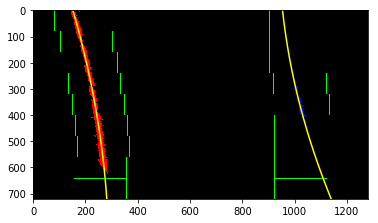

In [300]:
y_, left, right, cur_left, cur_right = sliding_windows(bit_warped)

In [198]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

NameError: name 'binary_warped' is not defined

In [150]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

NameError: name 'binary_warped' is not defined

In [68]:
def draw_lane_lines(orig_img, y_, left_fitx, right_fitx, M_inv):
    
    h,w = orig_img.shape[:2]
    lines_img = np.zeros([h,w]).astype(np.uint8)
    color_lines_img = np.dstack([lines_img, lines_img, lines_img])
    
    # gen points (x,y)
    left_pts = np.array([np.transpose(np.vstack([left_fitx, y_]))])
    # right lane points in reverse to work with cv2.fillPoly
    right_pts = np.array([np.flipud(np.transpose(np.vstack([right_fitx, y_])))])    
    all_pts = np.hstack([left_pts, right_pts])
    # first add the lines
    cv2.polylines(color_lines_img, np.int32(left_pts), isClosed=False, color=[255,255,0], thickness=10)
    cv2.polylines(color_lines_img, np.int32(right_pts), isClosed=False, color=[255,0,255], thickness=20)
    # now fill the area between the two lanes in green
    cv2.fillPoly(color_lines_img, np.int_([all_pts]), (0,255,0))
    # unwarp the image
    warped_lines = cv2.warpPerspective(color_lines_img, M_inv, (w,h))
    # add this to the original image
    output_img = cv2.addWeighted(orig_img, 1, warped_lines, 0.3, 0)
    
    return output_img   

In [69]:
out = gen_output_image(image, y_, left, right, M_inv)

NameError: name 'gen_output_image' is not defined

In [70]:
plt.imshow(out)

NameError: name 'out' is not defined

In [158]:
def add_curvature_info(img, left_cur, right_cur):
    out = np.copy(img)
    cv2.putText(out, 'left curvature: {0:.2f} meters'.format(left_cur), 
                (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,255,0), 2)
    cv2.putText(out, 'right curvature: {0:.2f} meters'.format(right_cur),
                (50,150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,255,0), 2)
    return out

In [159]:
out = add_curvature_info(out, cur_left, cur_right)

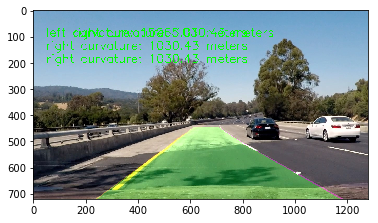

In [160]:
plt.imshow(out)

In [171]:
# takes in original image, performs various functions to generate an output

def pipeline(orig_img, mtx, dis):
    # undistort image
    undist_img = undistort_img(orig_img, mtx, dis)
    # apply gradient and hls thresholds
    bin_img = apply_thresh(undist_img, sobel_kernel=15, 
                 gradx_thresh=[2,100],angle_thresh=[0.5,2],
                 saturation_thresh=[80,255], hue_thresh=[0,255])
    # warp the image
    bin_warped_img, M_inv = warp(bin_img)
    # detect lanes using sliding windows
    y_, left, right, cur_left, cur_right = sliding_windows(bin_warped_img, nwinds=9, return_curvature=True)
    # draw the lanes in original image
    color_img_lines = draw_lane_lines(orig_img, y_, left, right, M_inv)
    # add curvature info
    output_img = add_curvature_info(color_img_lines, cur_left, cur_right)
    
    return output_img
    

In [172]:
image = plt.imread('./test_images/test4.jpg')

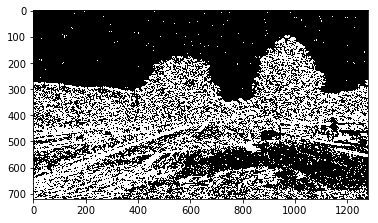

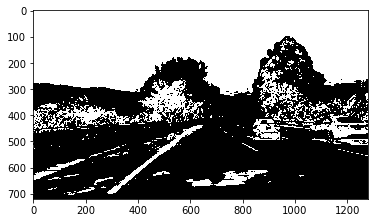

719.0 8530.16893081 1169.12726643


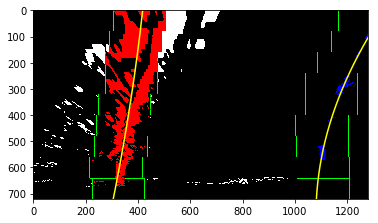

In [173]:
out = pipeline(image, mtx, dis)

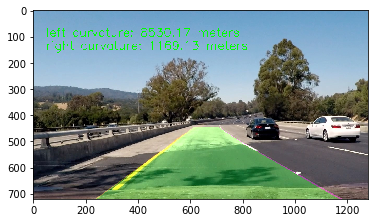

In [174]:
plt.imshow(out)